In [53]:
import chardet
import os
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD   
from nltk.tokenize import word_tokenize
import nltk

In [18]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()

    result = chardet.detect(raw_data)
    return result['encoding']

def srt_to_text(srt_file_path):
    encoding_attempts = ['utf-8', 'ISO-8859-1', 'utf-16', ]

    for encoding in encoding_attempts:
        try:
            with open(srt_file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()

            text = ""
            current_line = ""
            is_time_line = True

            for line in lines:
                line = line.strip()

                if not line:
                    is_time_line = True
                    continue

                if is_time_line:
                    is_time_line = False
                    continue

                current_line += line + " "

                # If the line ends with a punctuation indicating the end of a sentence
                if line.endswith(('.', '!', '?')):
                    text += current_line + "\n"
                    current_line = ""

            return text.strip()
        except UnicodeDecodeError:
            None

    # If none of the encodings work
    print(f"Unable to decode file: {srt_file_path}")
    return None

def process_srt_files_in_folder(folder_path):
    result_dict = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".srt"):
            srt_file_path = os.path.join(folder_path, filename)
            text_content = srt_to_text(srt_file_path)

            if text_content is not None:
                file_dict = {"name": filename, "text": text_content}
                result_dict.append(file_dict)

    return result_dict

# Example usage for a folder containing SRT files
wally = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/INFO 6350 - Text Mining History and Literature/INFO6350_Final_Project/srt_files'
casey = '/Users/caseykaufman/Documents/GitHub/INFO6350_Final_Project/srt_files'

folder_path = wally

result_dictionary = process_srt_files_in_folder(folder_path)

In [19]:
movie_subtitles_df = pd.DataFrame(result_dictionary)

In [20]:
# Removal of timestamps
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}[\s-]+', '\n', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'<font.*?>|<\/font>', '', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\bdownloaded.*?|subtitles downloaded.*?|http.*?|www.*?', '', regex=True, flags=re.IGNORECASE)

In [21]:
pd.options.display.max_rows = 400

In [22]:
years = []
for name_index in range(len(movie_subtitles_df['name'])):
    found_year = False
    for letter_index in range(len(movie_subtitles_df['name'][name_index])):
        if movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '19' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit() or movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '20' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit():
            y = movie_subtitles_df['name'][name_index][letter_index:letter_index+4]
            years.append(y)
            found_year = True
            break
    if not found_year:
        years.append('na')

In [23]:
movie_subtitles_df['years'] = years

In [24]:
movie_subtitles_df.head(10)

,name,text,years
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982
5,The.Sting.English-WWW.MY-SUBS.CO.srt,\nLet's see what you got. \n\nI need more runn...,na
6,Designing.Woman.1957.720p.BluRay.x264-[YTS.AM]...,\nMy name's Mike Hagen. \n\nI'm a sportswriter...,1957
7,Klute.English-WWW.MY-SUBS.CO.srt,\nCan I do this? What do I do? \nShall I do th...,na
8,The Tin Star (1957).srt,\nJust getting the feel of these guns. \n\nWhe...,1957
9,In Which We Serve (1942) - Eng Sub.srt,\nThis is the story of a ship \n(Cheering) \n(...,1942


In [25]:
#cleaning names
pattern1= r'^([^\d(]+)(?:\.\d{4}| \(\d{4}\))?\.?[^\w]*'
pattern2 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}\b'
pattern3 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}-'

clean_names = []
for file_name in movie_subtitles_df['name']:
    match = re.match(pattern1, file_name) or re.match(pattern2, file_name) or re.match(pattern3, file_name)
    if match:
        extracted_name = match.group(1).replace('.', ' ')
        clean_names.append(extracted_name)
    else:
        print("Name extraction pattern not found for:", file_name)
        
new = [name.split('WWW')[0].strip() if 'WWW' in name else name for name in clean_names]
clean_names = [x.replace('-','') for x in new]

In [26]:
movie_subtitles_df['Movie Name'] = clean_names

In [27]:
movie_subtitles_df.head()

,name,text,years,Movie Name
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi


## Basic Processing and Data Exploration

In [70]:
# Function to count tokens in a text
def count_tokens(text):
    tokens = nltk.word_tokenize(text)
    return len(tokens)

movie_subtitles_df['num_tokens'] = [count_tokens(movie_subtitles_df['text'][i]) for i in range(len(movie_subtitles_df['text']))]

In [75]:
# Sort the DataFrame by 'year' in ascending order
movie_subtitles_df = movie_subtitles_df.sort_values(by='years')

# Turn year counts into integers
movie_subtitles_df['year'] = movie_subtitles_df['years'].astype(int)

# Create a bar chart
plt.bar(movie_subtitles_df['years'], movie_subtitles_df['num_tokens'])
plt.xlabel('Years')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens by Year')
plt.xticks(range(min(movie_subtitles_df['years']), max(movie_subtitles_df['years'])+1, 20))
plt.show()

ValueError: invalid literal for int() with base 10: 'na'

## Create Chunks of Tokens out of the Paragraphs

In [28]:
# Create a topic model based on chunking with chunk size 200 tokens

def generate_chunks(paragraphs, movie, year, chunk_size=200):
    chunks = []
    chunk_movie_name = []
    chunk_year = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = movie.iloc[i]
        date = year.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_movie_name = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_movie_name.append(newsletter_type)
                chunk_year.append(date)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_movie_name.append(newsletter_type)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_year.extend([date])
                    chunk_movie_name.append(newsletter_type)
                    current_chunk = []
                    current_chunk_movie_name = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_year.extend([date])
            chunk_movie_name.append(newsletter_type)

    return chunks, chunk_movie_name, chunk_year

# Generate chunks
text_chunks, chunk_movie_name, chunk_year = generate_chunks(movie_subtitles_df['text'], movie_subtitles_df['name'], movie_subtitles_df['years'])

## Vectorize

In [29]:
# Vectorizer
vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25    # Ditto
)

In [30]:
# Vectorize
vectorizer = TfidfVectorizer(use_idf=True, norm=None)

In [31]:
# Vectorized texts
X_chunked = vectorizer.fit_transform(text_chunks)

#X_topics_chunked = StandardScaler().fit_transform(lda.fit_transform(X_chunked))

## KMeans Cluster Analysis

In [32]:
y_pred = KMeans(n_clusters=3, n_init='auto').fit_predict(X_chunked)

In [35]:
# Plotting function
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=3)
        X_2d = svd.fit_transform(X)
    else:
        X_2d = X

    # initialize figsize in prompt
    plt.figure(figsize=(12, 6))

    # left subplot, alpha value in function cell
    plt.subplot(121)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=alpha)
    plt.title("Dimension-Reduced Unclustered Data")

    # right subplot, same coordinate data and supplied cluster labels, alpha value in function cell
    plt.subplot(122)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=alpha)
    plt.title("Data with Clustering")

    # Set the common title for the entire figure
    plt.title(title)

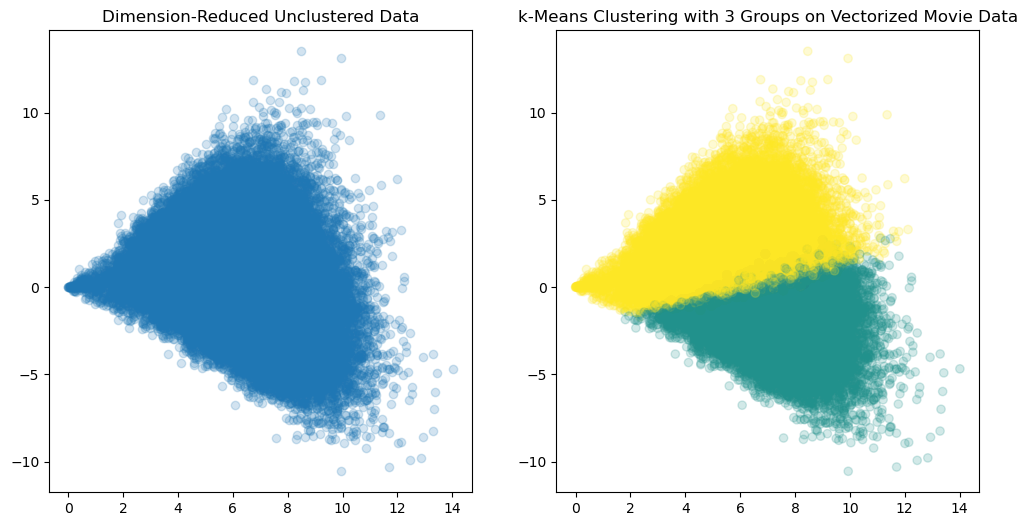

In [36]:
# plot resulting clustering
plot_compare(X_chunked, y_pred, 'k-Means Clustering with 3 Groups on Vectorized Movie Data')

# Topic Model

In [50]:
lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=0,       # Print progress
    max_iter=30,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X_chunked)

LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=20,
                          n_jobs=-1)

In [51]:
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)
        print(message)
    print()

In [52]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: music playing ha laughing sighs speaking tv radio whoa oh
Topic  1: you it to don what do me know that re
Topic  2: sir wait minute you yes the phone on please open
Topic  3: the and water of weeks feet in one ones land
Topic  4: the of to and war in is as our will
Topic  5: he problem is the bill news hospital his and richard
Topic  6: david questions buddy king paper yοu the howard slow jimmy
Topic  7: hello hi you bye hmm oh good john yeah is
Topic  8: you to and of the that it money not they
Topic  9: the in down on and we up they street city
Topic 10: and of the my your sweet daughter is to lie
Topic 11: police the blood lt horse president charge thе in of
Topic 12: he was she the him that and it had her
Topic 13: you get on shit fuck fucking hey up come man
Topic 14: the of is evening an you in yes mr to
Topic 15: years three the two five days four of in for
Topic 16: the school of game in he and high to win
Topic 17: the head car your on eyes goes she ya in
Topic 18: t